# Stacked Autoencoder Model

### Loading Data

In [2]:
import os
from skimage.feature import hog
from skimage import exposure
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Model
import cv2

import seaborn as sns
import matplotlib.pyplot as plt




In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
base_path = '/content/drive/.shortcut-targets-by-id/1W01KwNde9fWkWs9206tNtZsdc3BVs97m/anomaly/mvtec_anomaly_detection/'


In [5]:
# Set random seeds for reproducibility
random_seed = 47

# Set the random seed for NumPy
np.random.seed(random_seed)

# Set the random seed for TensorFlow
tf.random.set_seed(random_seed)

In [6]:
# Specify the list of classes (folders)
classes = ["zipper", "wood", "transistor", "toothbrush", "tile", "screw", "pill", "metal_nut", "leather", "hazelnut", "grid", "carpet", "capsule", "cable", "bottle"]


In [7]:
def load_and_preprocess_image(image_path, target_size=(180, 180)):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    # Resize the image to the target size
    image = cv2.resize(image, target_size)
    # Normalize the pixel values to the [0, 1] range
    image = image.astype("float32") / 255.0
    return image

In [8]:
# Initialize lists to store images and labels
images_train = []
labels_train = []

images_test = []
labels_test = []


In [9]:
# Load and preprocess the images for the training dataset (only "good" class)
for class_name in classes:
    train_folder = os.path.join(base_path, class_name, "train", "good")

    for filename in os.listdir(train_folder):
        image_path = os.path.join(train_folder, filename)
        image = load_and_preprocess_image(image_path, target_size=(180, 180))
        images_train.append(image)
        labels_train.append(0)


In [10]:
print('Dimension of objects in the list images_train: ', images_train[0].shape)
print('Number of samples in the list images_train: ', len(images_train))



Dimension of objects in the list images_train:  (180, 180, 3)
Number of samples in the list images_train:  3629


In [11]:
# Load and preprocess the images for the testing dataset (both "good" and "defected" classes)
for class_name in classes:
    test_folder = os.path.join(base_path, class_name, "test")

    for folder_name in os.listdir(test_folder):
        defect_folder = os.path.join(test_folder, folder_name)

        for filename in os.listdir(defect_folder):
            image_path = os.path.join(defect_folder, filename)
            image = load_and_preprocess_image(image_path, target_size=(180, 180))
            images_test.append(image)
            labels_test.append(0 if folder_name == "good" else 1)


In [12]:
print('Dimension of objects in the list images_test: ', images_test[0].shape)
print('Number of samples in the list images_test: ', len(images_test))


Dimension of objects in the list images_test:  (180, 180, 3)
Number of samples in the list images_test:  1725


In [13]:
# Convert the data to numpy arrays
X_train = np.array(images_train)
X_test = np.array(images_test)

# Normalize pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [14]:
X_train[0].shape, X_test[0].shape

((180, 180, 3), (180, 180, 3))

### Simple Stacked Autoencoder Model

In [14]:
# Stacked Autoencoder for Color Images
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation="relu"),
    tf.keras.layers.Dense(1, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(2, activation="relu"),
    tf.keras.layers.Dense(180 * 180 * 3),
    tf.keras.layers.Reshape([180, 180, 3])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="mse", optimizer="nadam")

In [15]:
# Train the stacked autoencoder with X_train as both input and output
history = stacked_ae.fit(X_train, X_train, epochs=20)

Epoch 1/20
114/114 [==============================] - 8s 11ms/step - loss: 1.1012e-06
Epoch 2/20
114/114 [==============================] - 1s 11ms/step - loss: 9.9702e-07
Epoch 3/20
114/114 [==============================] - 1s 11ms/step - loss: 9.9811e-07
Epoch 4/20
114/114 [==============================] - 1s 11ms/step - loss: 9.9858e-07
Epoch 5/20
114/114 [==============================] - 1s 11ms/step - loss: 9.9687e-07
Epoch 6/20
114/114 [==============================] - 1s 11ms/step - loss: 9.9719e-07
Epoch 7/20
114/114 [==============================] - 1s 11ms/step - loss: 9.9748e-07
Epoch 8/20
114/114 [==============================] - 1s 11ms/step - loss: 9.9711e-07
Epoch 9/20
114/114 [==============================] - 1s 11ms/step - loss: 9.9701e-07
Epoch 10/20
114/114 [==============================] - 1s 11ms/step - loss: 9.9679e-07
Epoch 11/20
114/114 [==============================] - 1s 11ms/step - loss: 9.9708e-07
Epoch 12/20
114/114 [==============================]

In [16]:
# Use the trained autoencoder to reconstruct images from X_test
reconstructed_images = stacked_ae.predict(X_test)

# Calculate reconstruction errors (MSE)
reconstruction_errors = np.mean(np.square(X_test - reconstructed_images), axis=(1, 2, 3))


54/54 [==============================] - 0s 6ms/step


In [17]:
reconstruction_errors

array([1.3792015e-06, 1.4289075e-06, 1.4090452e-06, ..., 2.0997693e-06,
       2.1272122e-06, 2.1303063e-06], dtype=float32)

In [18]:
# Define the desired percentile (e.g., 95th percentile)
desired_percentile = 50


# Calculate the threshold as the specified percentile
threshold_precentile = np.percentile(reconstruction_errors, desired_percentile)

# Print the calculated threshold
print(f"Threshold at {desired_percentile}th percentile: {threshold_precentile:.2e}")

Threshold at 50th percentile: 8.83e-07


In [19]:
# Set an anomaly detection threshold (adjust as needed)
threshold = threshold_precentile

# Identify defected images based on the threshold
defected_indices = np.where(reconstruction_errors > threshold)[0]
defected_images = X_test[defected_indices]


In [20]:
len(defected_images)

862

In [21]:
# Create predicted_labels array
predicted_labels = np.zeros(len(X_test))
predicted_labels[defected_indices] = 1

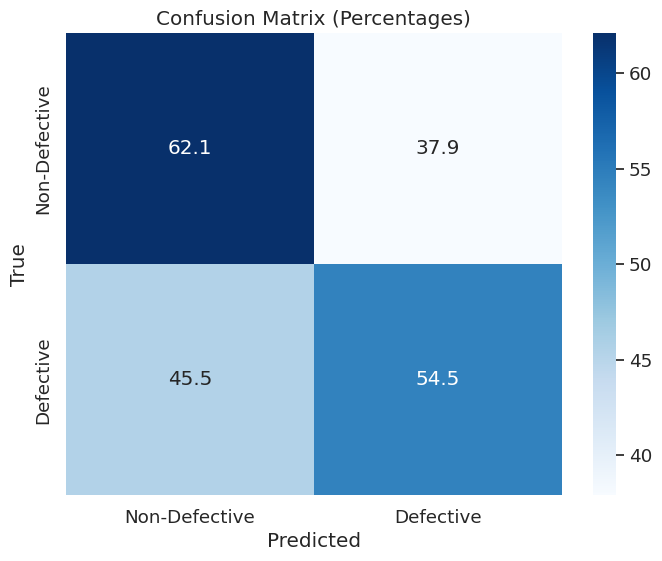

Confusion Matrix:
[[290 177]
 [573 685]]
True Positives (TP): 685
False Positives (FP): 177
True Negatives (TN): 290
False Negatives (FN): 573
Precision: 0.795
Accuracy: 0.565
Recall: 0.545
F1-Score: 0.646


In [22]:
# Create the confusion matrix
confusion_mat = confusion_matrix(labels_test, predicted_labels)

# Calculate TP, FP, TN, FN values
TP = confusion_mat[1, 1]
FP = confusion_mat[0, 1]
TN = confusion_mat[0, 0]
FN = confusion_mat[1, 0]

# Calculate precision, recall, and F1-score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + FP + TN + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Create a confusion matrix plot (percentages)
cm_percentage = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["Non-Defective", "Defective"],
            yticklabels=["Non-Defective", "Defective"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentages)')
plt.show()

# Print confusion matrix and metrics
print("Confusion Matrix:")
print(confusion_mat)
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")
print(f"Precision: {precision:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1_score:.3f}")


### Augmanted Stacked Autoencoder Model

In [15]:
# Specify data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomTranslation(0.2, 0.2)
])


In [16]:
# Apply data augmentation to images_train
augmented_images_train = data_augmentation(images_train)

# Convert the augmented images to numpy array
X_train_augmented = np.array(augmented_images_train)

In [17]:
# Concatenate the original X_train and augmented images to create an expanded training dataset
expanded_X_train = np.concatenate((X_train, X_train_augmented), axis=0)

In [18]:
# Update labels_train to account for augmented images
original_labels_train = [0] * len(X_train)
augmented_labels_train = [0] * len(X_train_augmented)
expanded_labels_train = original_labels_train + augmented_labels_train

In [19]:
print('Number of samples in the list expanded_X_train: ', len(expanded_X_train))
print('Number of samples in the list expanded_labels_train: ', len(expanded_labels_train))


Number of samples in the list expanded_X_train:  7258
Number of samples in the list expanded_labels_train:  7258


In [100]:
# Define and train a stacked autoencoder model with the expanded training dataset
stacked_encoder_expanded = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(7, activation="relu"),
])
stacked_decoder_expanded = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(180 * 180 * 3),
    tf.keras.layers.Reshape([180, 180, 3])
])
stacked_ae_expanded = tf.keras.Sequential([stacked_encoder_expanded, stacked_decoder_expanded])
stacked_ae_expanded.compile(loss="mse", optimizer="nadam")

In [101]:
# Train the stacked autoencoder with expanded_X_train as both input and output
history_expanded = stacked_ae_expanded.fit(expanded_X_train, expanded_X_train, epochs=20)


Epoch 1/20
227/227 [==============================] - 4s 10ms/step - loss: 0.0180
Epoch 2/20
227/227 [==============================] - 2s 10ms/step - loss: 0.0140
Epoch 3/20
227/227 [==============================] - 2s 10ms/step - loss: 0.0131
Epoch 4/20
227/227 [==============================] - 2s 10ms/step - loss: 0.0128
Epoch 5/20
227/227 [==============================] - 2s 10ms/step - loss: 0.0127
Epoch 6/20
227/227 [==============================] - 2s 10ms/step - loss: 0.0129
Epoch 7/20
227/227 [==============================] - 2s 10ms/step - loss: 0.0125
Epoch 8/20
227/227 [==============================] - 2s 10ms/step - loss: 0.0125
Epoch 9/20
227/227 [==============================] - 2s 10ms/step - loss: 0.0125
Epoch 10/20
227/227 [==============================] - 2s 10ms/step - loss: 0.0125
Epoch 11/20
227/227 [==============================] - 2s 10ms/step - loss: 0.0124
Epoch 12/20
227/227 [==============================] - 2s 10ms/step - loss: 0.0123
Epoch 13/20
2

In [102]:
# Use the trained stacked autoencoder to reconstruct images from X_test
reconstructed_images_expanded = stacked_ae_expanded.predict(X_test)

# Calculate reconstruction errors (MSE)
reconstruction_errors_expanded = np.mean(np.square(X_test - reconstructed_images_expanded), axis=(1, 2, 3))

54/54 [==============================] - 0s 4ms/step


In [103]:
reconstruction_errors_expanded

array([2.7008468e-06, 2.7722256e-06, 2.5754020e-06, ..., 7.9746160e-06,
       7.9985721e-06, 8.1772187e-06], dtype=float32)

In [104]:
desired_percentile_expanded = 50

In [105]:
# Calculate the threshold as the specified percentile
threshold_percentile_expanded = np.percentile(reconstruction_errors_expanded, desired_percentile_expanded)

# Print the calculated threshold
print(f"Threshold at {desired_percentile_expanded}th percentile: {threshold_percentile_expanded:.2e}")


Threshold at 50th percentile: 2.68e-06


In [106]:
# Set an anomaly detection threshold (adjust as needed)
threshold_expanded = threshold_percentile_expanded

# Identify defected images based on the threshold
defected_indices_expanded = np.where(reconstruction_errors_expanded > threshold_expanded)[0]
defected_images_expanded = X_test[defected_indices_expanded]


In [107]:
len(defected_images_expanded)

862

In [108]:
# Create predicted_labels array
predicted_labels_expanded = np.zeros(len(X_test))
predicted_labels_expanded[defected_indices_expanded] = 1

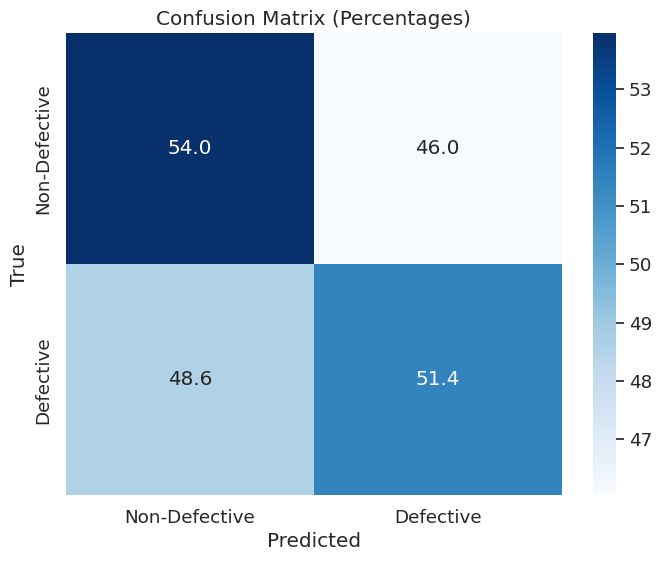

Confusion Matrix:
[[252 215]
 [611 647]]
True Positives (TP_exp): 647
False Positives (FP_exp): 215
True Negatives (TN_exp): 252
False Negatives (FN_exp): 611
Precision_exp: 0.751
Accuracy_exp: 0.521
Recall_exp: 0.514
F1-Score_exp: 0.610


In [109]:
# Create the confusion matrix
confusion_mat_exp = confusion_matrix(labels_test, predicted_labels_expanded)

# Calculate TP, FP, TN, FN values
TP_exp = confusion_mat_exp[1, 1]
FP_exp = confusion_mat_exp[0, 1]
TN_exp = confusion_mat_exp[0, 0]
FN_exp = confusion_mat_exp[1, 0]

# Calculate precision, recall, and F1-score
precision_exp = TP_exp / (TP_exp + FP_exp)
recall_exp = TP_exp / (TP_exp + FN_exp)
accuracy_exp = (TP_exp + TN_exp) / (TP_exp + FP_exp + TN_exp + FN_exp)
f1_score_exp = 2 * (precision_exp * recall_exp) / (precision_exp + recall_exp)

# Create a confusion matrix plot (percentages)
cm_percentage_exp = confusion_mat_exp.astype('float') / confusion_mat_exp.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_percentage_exp, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["Non-Defective", "Defective"],
            yticklabels=["Non-Defective", "Defective"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentages)')
plt.show()

# Print confusion matrix and metrics
print("Confusion Matrix:")
print(confusion_mat_exp)
print(f"True Positives (TP_exp): {TP_exp}")
print(f"False Positives (FP_exp): {FP_exp}")
print(f"True Negatives (TN_exp): {TN_exp}")
print(f"False Negatives (FN_exp): {FN_exp}")
print(f"Precision_exp: {precision_exp:.3f}")
print(f"Accuracy_exp: {accuracy_exp:.3f}")
print(f"Recall_exp: {recall_exp:.3f}")
print(f"F1-Score_exp: {f1_score_exp:.3f}")

Augmanted model could not help to generate better identification of defected objects. Moreover, with augmanted model more complex models work better, but improvment is inverted U shape. After (20,10) - (20) for layers in the stacked model, predictions deteriorate. The best precision was 0.791.